**Projeto Personalizado - Recomendação de filmes**

---
Aluno: Juarez Angelo Piazza Sacenti

Resumo: Sistemas de Recomendação (SR) predizem para um dado usuário quais os filmes de seu maior interesse, com o intuito de reduzir a sobrecarga de informação decorrente do volume cada vez maior de itens em sistemas de streaming, e-commerce e repositórios digitais. Este Jupyter Notebook apresenta um projeto de aprendizado de máquina que objetiva a recomendação de filmes para usuários descritos pelo conjunto de dados Movilens 1M, utilizando a linguagem Python e as bibliotecas scikit-learn e surprise. Para este projeto, adotamos métricas de erro (MSE, RMSE e MAE) para identificar o SR que melhor prediz o valor da avaliação de usuário para filme assistido.

# Index

1. Configuração Inicial;

2. Enquadrar o problema;

3. Descrição do conjunto de dados - ML1M;
               
4. Separação em treino e teste;

5. Análise Exploratória dos Dados (AED);

6. Feature Engineering;

7. Pré-processamento dos dados;

8. Validação cruzada e hiperparametrização;

9. Teste de generalização;

10. Conclusão.

# 1. Configuração inicial

Esta secção realiza a configuração inicial do notebook, que envolve a importação de bibliotecas utilizadas, diretivas para ignorar avisos, definição do diretório para figuras e definição da semente aleatória. 

In [1]:
# Importações de bibliotecas
import os
import random
import numpy as np
import pandas as pd
from wordcloud import WordCloud, STOPWORDS # para plotar nuvens de palavras

In [2]:
# Ignorar warnings desnecessários (ver SciPy issue #5998)
import warnings
warnings.filterwarnings(action="ignore", message="^internal gelsd")

In [3]:
# Para plotar figuras
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

[Confira aqui](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.rc.html) a documentação do matplotlib.rc

In [4]:
# Para salvar figuras geradas
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "end_to_end_project"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

In [5]:
# Para garantir estabilidade e ser mais fácil reproduzir experimento
np.random.seed(42)

# 2. Enquadar o problema

Sistemas como streaming, e-commerce e repositórios digitais colocam a disposição um volume cada vez maior de itens a seus usuários, o que dificulta a seleção de itens de seu interesse devido ao problema da sobrecarga de informação. Para atenuar este problema, Sistemas de Recomendação (SR) predizem para um dado usuário quais os filmes de seu maior interesse. 

Um recomendador pode adotar diversas estratégias (e.g., popularidade, novidade, diversidade, baseadas no conteúdo de itens, abordagens colaborativas) e assim necessitar de diferentes tipos de informação (e.g., interações usuário-item, características de usuários e items, restrições, informações de contexto espacial e temporal, confiança entre usuários). Geralmente, o recomendador realiza um aprendizado supevisionado para embasar suas predições, cujos rótulos podem ser feedback explícitos (e.g., avaliação manual do usuário relativa ao item) ou implícitos (e.g., clique, número de acessos, tempo de visita, compra do produto) e suas recomendações resultantes de regressão (i.e., predição da nota de um item ainda não avaliado) ou classificação (i.e., se o item é de interesse ou não). Deste modo, um SR pode ter diferentes objetivos, como:

- Predizer o valor da avaliação de usuário para filme assistido.

- Classificar se um filme será ou não assistido pelo usuário.

- Recomendar um grupo de filmes com maior possibilidade de escolha do usuário e maior diversidade entre os filmes. (confrontamento de exploitation e exploration)

- Determinar o modelo que obtenha maior satisfação para o cliente e/ou empresa?! (confrontamento de testes offlines e onlines)

Este Jupyter Notebook apresenta um projeto de aprendizado de máquina supervisionado que objetiva a recomendação de filmes para usuários descritos por MovieLens 1M (ML1M) (Harper and Konstan, 2015), utilizando a linguagem Python e as bibliotecas scikit-learn e surprise. Para este projeto, adotamos métricas de erro (MSE, RMSE e MAE) para identificar o SR que melhor prediz o valor da avaliação de usuário para filme assistido.

ML1M é um conjunto de dados adotado desde 2003 para comparação estável de performance e desempenho de SRs, com cerca de 1 milhão de avaliações de 6000 usuários em 4000 filmes coletadas no ano de 2000. No ML1M, itens são avaliados por usuários em uma escala de 5 estrelas (números inteiros 1-5). A próxima secção descreve este conjunto de dados, e as subsequentes apresentam a estratégia de separação em treino e teste, a Análise Exploratória dos Dados (AED), feature engineering, o pré-processamento dos dados; a validação cruzada e hiperparametrização, teste de generalização e a conclusão deste projeto.

# 3. Descrição do conjunto de dados - ML1M

Informações do arquivo README.txt e de investigações realizadas nos arquivos ratings.dat, movies.dat e users.dat.

ratigns.dat: UserID::MovieID::Rating::Timestamp
- UserIDs range between 1 and 6040 
- MovieIDs range between 1 and 3952
- Ratings are made on a 5-star scale (whole-star ratings only)
- Timestamp is represented in seconds since the epoch as returned by time(2)
- Each user has at least 20 ratings

users.dat: UserID::Gender::Age::Occupation::Zip-code

All demographic information is provided voluntarily by the users and is not checked for accuracy.  Only users who have provided some demographic information are included in this data set.

- Gender is denoted by a "M" for male and "F" for female
- Age is chosen from the following ranges:

	*  1:  "Under 18"
	* 18:  "18-24"
	* 25:  "25-34"
	* 35:  "35-44"
	* 45:  "45-49"
	* 50:  "50-55"
	* 56:  "56+"
- Occupation is chosen from the following choices:
	*  0:  "other" or not specified
	*  1:  "academic/educator"
	*  2:  "artist"
	*  3:  "clerical/admin"
	*  4:  "college/grad student"
	*  5:  "customer service"
	*  6:  "doctor/health care"
	*  7:  "executive/managerial"
	*  8:  "farmer"
	*  9:  "homemaker"
	* 10:  "K-12 student"
	* 11:  "lawyer"
	* 12:  "programmer"
	* 13:  "retired"
	* 14:  "sales/marketing"
	* 15:  "scientist"
	* 16:  "self-employed"
	* 17:  "technician/engineer"
	* 18:  "tradesman/craftsman"
	* 19:  "unemployed"
	* 20:  "writer"
    
movies.dat: MovieID::Title::Genres
- Titles are identical to titles provided by the IMDB (including
year of release)
- Genres are pipe-separated and are selected from the following genres:
	* Action
	* Adventure
	* Animation
	* Children's
	* Comedy
	* Crime
	* Documentary
	* Drama
	* Fantasy
	* Film-Noir
	* Horror
	* Musical
	* Mystery
	* Romance
	* Sci-Fi
	* Thriller
	* War
	* Western
- Some MovieIDs do not correspond to a movie due to accidental duplicate
entries and/or test entries
- Movies are mostly entered by hand, so errors and inconsistencies may exist

## 3.1. Obtenção os dados

In [6]:
from zipfile import ZipFile 
from six.moves import urllib

ML1M_ROOT = "http://files.grouplens.org/datasets/movielens/"
ML1M_PATH = os.path.join("..", "..", "datasets", "ml1m")
ML1M_FILE =  "ml-1m.zip"
ML1M_MD5 = ML1M_ROOT + ML1M_FILE + ".md5"

def fetch_ml1m_data(filename=ML1M_FILE, download_root=ML1M_ROOT, save_path=ML1M_PATH):
    os.makedirs(save_path, exist_ok=True) #Cria diretorio
    file_path = os.path.join(save_path, filename) #caminho do arquivo
    download_url = os.path.join(download_root, filename) #url do arquivo
    urllib.request.urlretrieve(download_url, file_path)
    with ZipFile(file_path) as ml1m_zip:
        ml1m_zip.extractall(path=save_path)

In [7]:
fetch_ml1m_data() #Cria diretório datasets/ml1m

In [8]:
# https://www.kaggle.com/cesarcf1977/movielens-data-analysis-beginner-s-first
# from http://www.gregreda.com/2013/10/26/using-pandas-on-the-movielens-dataset/
def load_ml1m_data(save_path=ML1M_PATH):
    # pass in column names for each CSV
    csv_path = os.path.join(save_path, "ml-1m", "users.dat")
    u_cols = ['user_id', 'gender', 'age', 'occupation', 'zip_code']
    users = pd.read_csv(csv_path, sep='::', engine="python", names=u_cols, encoding='utf8')

    csv_path = os.path.join(save_path, "ml-1m", "ratings.dat")
    r_cols = ['user_id', 'movie_id', 'rating', 'unix_timestamp']
    ratings = pd.read_csv(csv_path, sep='::', engine="python", names=r_cols, encoding='utf8')

    # the movies file contains columns indicating the movie's genres
    # let's only load the first five columns of the file with usecols
    csv_path = os.path.join(save_path, "ml-1m", "movies.dat")
    m_cols = ['movie_id', 'title', 'genres']
    movies = pd.read_csv(csv_path, sep="::", engine="python", names=m_cols, usecols=range(5), encoding='latin-1')

    # create one merged DataFrame
    movie_ratings = pd.merge(movies, ratings)
    lens = pd.merge(movie_ratings, users)
    return users, ratings, movies, movie_ratings, lens

In [9]:
users, ratings, movies, movie_ratings, lens = load_ml1m_data()
lens.head() #visualizar as 5 primeiras linhas do dataframe

,movie_id,title,genres,user_id,rating,unix_timestamp,gender,age,occupation,zip_code
0,1,Toy Story (1995),Animation|Children's|Comedy,1,5,978824268,F,1,10,48067
1,48,Pocahontas (1995),Animation|Children's|Musical|Romance,1,5,978824351,F,1,10,48067
2,150,Apollo 13 (1995),Drama,1,5,978301777,F,1,10,48067
3,260,Star Wars: Episode IV - A New Hope (1977),Action|Adventure|Fantasy|Sci-Fi,1,4,978300760,F,1,10,48067
4,527,Schindler's List (1993),Drama|War,1,5,978824195,F,1,10,48067


In [10]:
lens.info() #Rápida descrição dos dados

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1000209 entries, 0 to 1000208
Data columns (total 10 columns):
movie_id          1000209 non-null int64
title             1000209 non-null object
genres            1000209 non-null object
user_id           1000209 non-null int64
rating            1000209 non-null int64
unix_timestamp    1000209 non-null int64
gender            1000209 non-null object
age               1000209 non-null int64
occupation        1000209 non-null int64
zip_code          1000209 non-null object
dtypes: int64(6), object(4)
memory usage: 83.9+ MB


## 3.2. Variáveis numéricas

In [11]:
users.describe() #Medidas resumo

,user_id,age,occupation
count,6040.000000,6040.000000,6040.000000
mean,3020.500000,30.639238,8.146854
std,1743.742145,12.895962,6.329511
min,1.000000,1.000000,0.000000
25%,1510.750000,25.000000,3.000000
50%,3020.500000,25.000000,7.000000
75%,4530.250000,35.000000,14.000000
max,6040.000000,56.000000,20.000000


In [12]:
ratings.describe() #Medidas resumo

,user_id,movie_id,rating,unix_timestamp
count,1.000209e+06,1.000209e+06,1.000209e+06,1.000209e+06
mean,3.024512e+03,1.865540e+03,3.581564e+00,9.722437e+08
std,1.728413e+03,1.096041e+03,1.117102e+00,1.215256e+07
min,1.000000e+00,1.000000e+00,1.000000e+00,9.567039e+08
25%,1.506000e+03,1.030000e+03,3.000000e+00,9.653026e+08
50%,3.070000e+03,1.835000e+03,4.000000e+00,9.730180e+08
75%,4.476000e+03,2.770000e+03,4.000000e+00,9.752209e+08
max,6.040000e+03,3.952000e+03,5.000000e+00,1.046455e+09


In [13]:
movies.describe() #Medidas resumo

,movie_id
count,3883.000000
mean,1986.049446
std,1146.778349
min,1.000000
25%,982.500000
50%,2010.000000
75%,2980.500000
max,3952.000000


## 3.3. Variáveis categóricas

4 características são categóricas: title, genres, gender e zip_code.

In [14]:
movies["title"].value_counts()

House (1986)                                                  1
Blood & Wine (1997)                                           1
Birds, The (1963)                                             1
Stonewall (1995)                                              1
Home Alone (1990)                                             1
Lock, Stock & Two Smoking Barrels (1998)                      1
Hurricane, The (1999)                                         1
Nowhere (1997)                                                1
Midnight Dancers (Sibak) (1994)                               1
Hot Spot, The (1990)                                          1
While You Were Sleeping (1995)                                1
Seventh Sign, The (1988)                                      1
Blackbeard's Ghost (1968)                                     1
Parent Trap, The (1961)                                       1
Boys, Les (1997)                                              1
Craft, The (1996)                       

Cada um dos 3883 filmes possui um título distinto. 

In [15]:
movies["genres"].value_counts()

Drama                                    843
Comedy                                   521
Horror                                   178
Comedy|Drama                             162
Comedy|Romance                           142
Drama|Romance                            134
Documentary                              116
Thriller                                 101
Action                                    65
Drama|Thriller                            63
Action|Thriller                           48
Children's|Comedy                         47
Crime|Drama                               44
Drama|War                                 43
Romance                                   40
Action|Drama                              39
Animation|Children's                      35
Comedy|Drama|Romance                      34
Horror|Sci-Fi                             33
Western                                   33
Horror|Thriller                           32
Comedy|Horror                             31
Adventure|

Como podemos observar, a característica "genres" é uma variável multivalorada, com 301 combinações de 18 gêneros de filmes. 

From https://www.kaggle.com/jneupane12/analysis-of-movielens-dataset-beginner-sanalysis

In [16]:
#define a function that counts the number of times each genre appear:
def count_word(df, ref_col, liste):
    keyword_count = dict()
    for s in liste: keyword_count[s] = 0
    for liste_keywords in df[ref_col].str.split('|'):
        if type(liste_keywords) == float and pd.isnull(liste_keywords): continue
        for s in liste_keywords: 
            if pd.notnull(s): keyword_count[s] += 1
    # convert the dictionary in a list to sort the keywords  by frequency
    keyword_occurences = []
    for k,v in keyword_count.items():
        keyword_occurences.append([k,v])
    keyword_occurences.sort(key = lambda x:x[1], reverse = True)
    return keyword_occurences, keyword_count

In [17]:
#here we  make census of the genres:
genre_labels = set()
for s in movies['genres'].str.split('|').values:
    genre_labels = genre_labels.union(set(s))

In [18]:
#counting how many times each of genres occur:
keyword_occurences, dum = count_word(movies, 'genres', genre_labels)
keyword_occurences

[['Drama', 1603],
 ['Comedy', 1200],
 ['Action', 503],
 ['Thriller', 492],
 ['Romance', 471],
 ['Horror', 343],
 ['Adventure', 283],
 ['Sci-Fi', 276],
 ["Children's", 251],
 ['Crime', 211],
 ['War', 143],
 ['Documentary', 127],
 ['Musical', 114],
 ['Mystery', 106],
 ['Animation', 105],
 ['Western', 68],
 ['Fantasy', 68],
 ['Film-Noir', 44]]

Separando em 18 genres:

In [19]:
genres_unique = pd.DataFrame(movies.genres.str.split('|').tolist()).stack().unique()
genres_unique = pd.DataFrame(genres_unique, columns=['genre']) # Format into DataFrame to store later

In [20]:
new_movies = movies.join(movies.genres.str.get_dummies())
new_movies.drop('genres', inplace=True, axis=1)

In [21]:
new_movies.head()

,movie_id,title,Action,Adventure,Animation,Children's,Comedy,Crime,Documentary,Drama,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
0,1,Toy Story (1995),0,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0
1,2,Jumanji (1995),0,1,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0
2,3,Grumpier Old Men (1995),0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0
3,4,Waiting to Exhale (1995),0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0
4,5,Father of the Bride Part II (1995),0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0


In [22]:
new_movies.describe()

,movie_id,Action,Adventure,Animation,Children's,Comedy,Crime,Documentary,Drama,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
count,3883.000000,3883.000000,3883.000000,3883.000000,3883.000000,3883.000000,3883.000000,3883.000000,3883.000000,3883.000000,3883.000000,3883.000000,3883.000000,3883.000000,3883.000000,3883.000000,3883.000000,3883.000000,3883.000000
mean,1986.049446,0.129539,0.072882,0.027041,0.064641,0.309039,0.054339,0.032707,0.412825,0.017512,0.011331,0.088334,0.029359,0.027298,0.121298,0.071079,0.126706,0.036827,0.017512
std,1146.778349,0.335839,0.259976,0.162224,0.245923,0.462157,0.226715,0.177891,0.492405,0.131187,0.105858,0.283816,0.168832,0.162973,0.326515,0.256990,0.332686,0.188362,0.131187
min,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,982.500000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,2010.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,2980.500000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,3952.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [23]:
users["gender"].value_counts()

M    4331
F    1709
Name: gender, dtype: int64

In [24]:
users["zip_code"].value_counts()

48104     19
22903     18
55104     17
94110     17
55105     16
55455     16
10025     16
02138     15
94114     15
55408     15
90024     14
98103     14
94117     14
48103     13
10016     13
90210     13
37922     13
60640     13
55406     12
10003     11
55405     11
02139     11
48105     11
55113     11
10011     10
02143     10
13210     10
55116     10
97330     10
60201     10
          ..
44325      1
92675      1
76309      1
60538      1
92404      1
32308      1
43138      1
91780      1
90019      1
30071      1
21050      1
96778      1
98055      1
10310      1
29681      1
55435      1
04074      1
60435      1
98632      1
22309      1
02356      1
75013      1
37743      1
99114      1
96930      1
444555     1
24179      1
33030      1
92595      1
08003      1
Name: zip_code, Length: 3439, dtype: int64

## 3.4. Cleanning data

In [25]:
#is any row null
users.isnull().any()

user_id       False
gender        False
age           False
occupation    False
zip_code      False
dtype: bool

In [26]:
#is any row null
movies.isnull().any()

movie_id    False
title       False
genres      False
dtype: bool

In [27]:
#is any row null
ratings.isnull().any()

user_id           False
movie_id          False
rating            False
unix_timestamp    False
dtype: bool

## 3.5. Data visualization

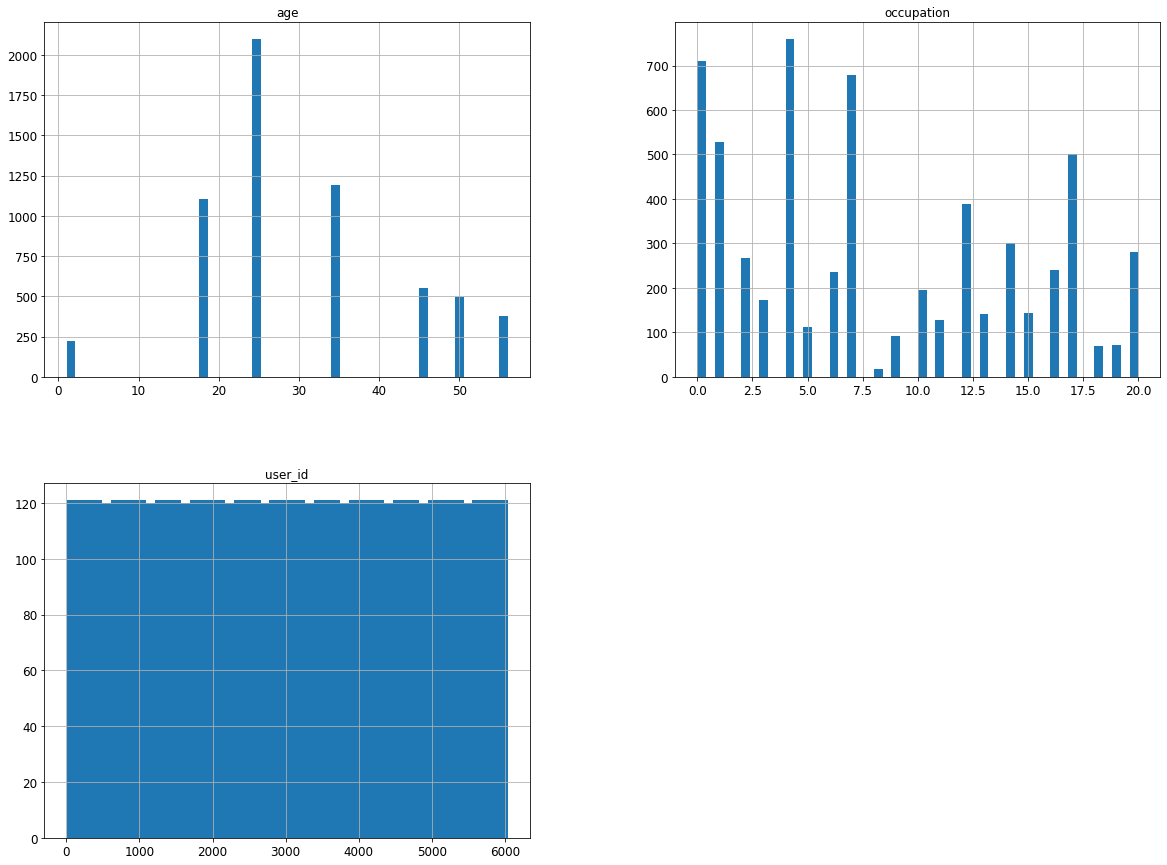

In [28]:
%matplotlib inline
import matplotlib.pyplot as plt
users.hist(bins=50, figsize=(20,15))
plt.show()

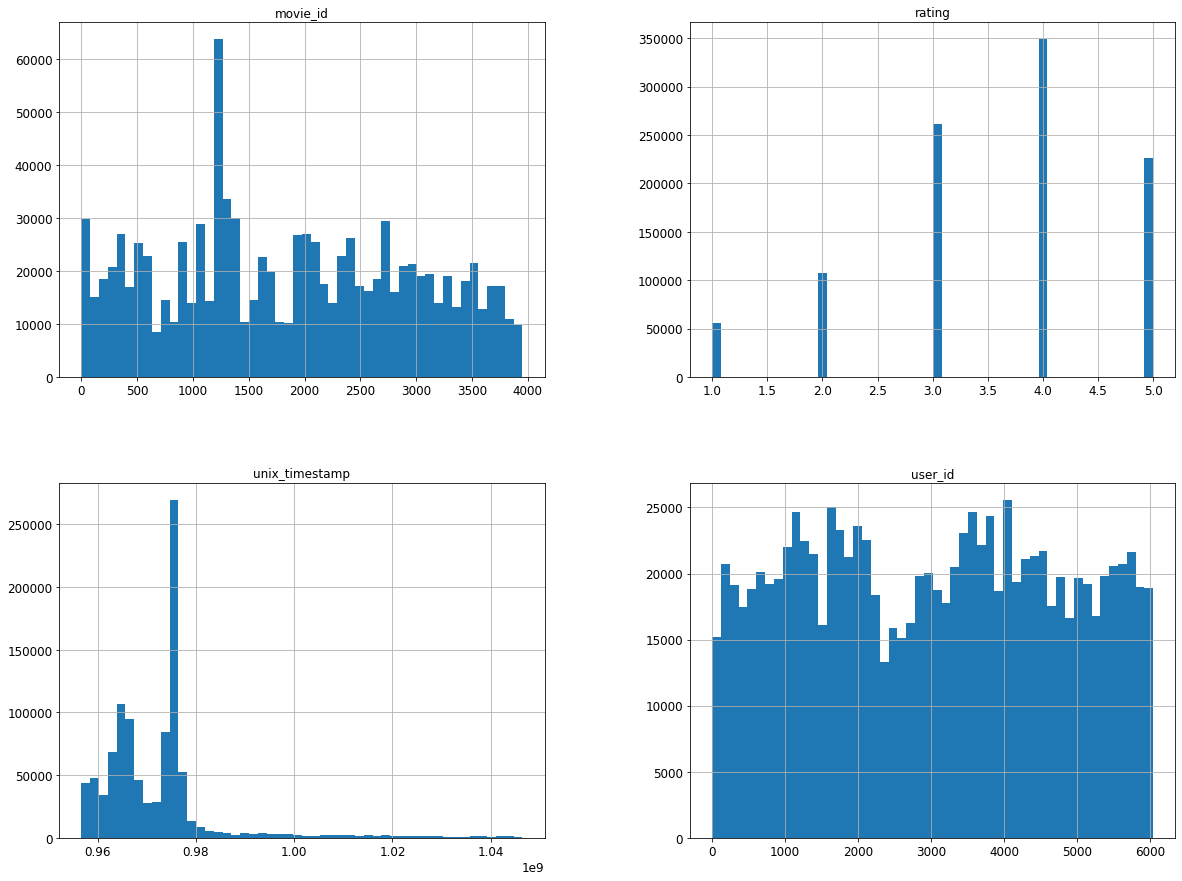

In [29]:
%matplotlib inline
import matplotlib.pyplot as plt
ratings.hist(bins=50, figsize=(20,15))
plt.show()

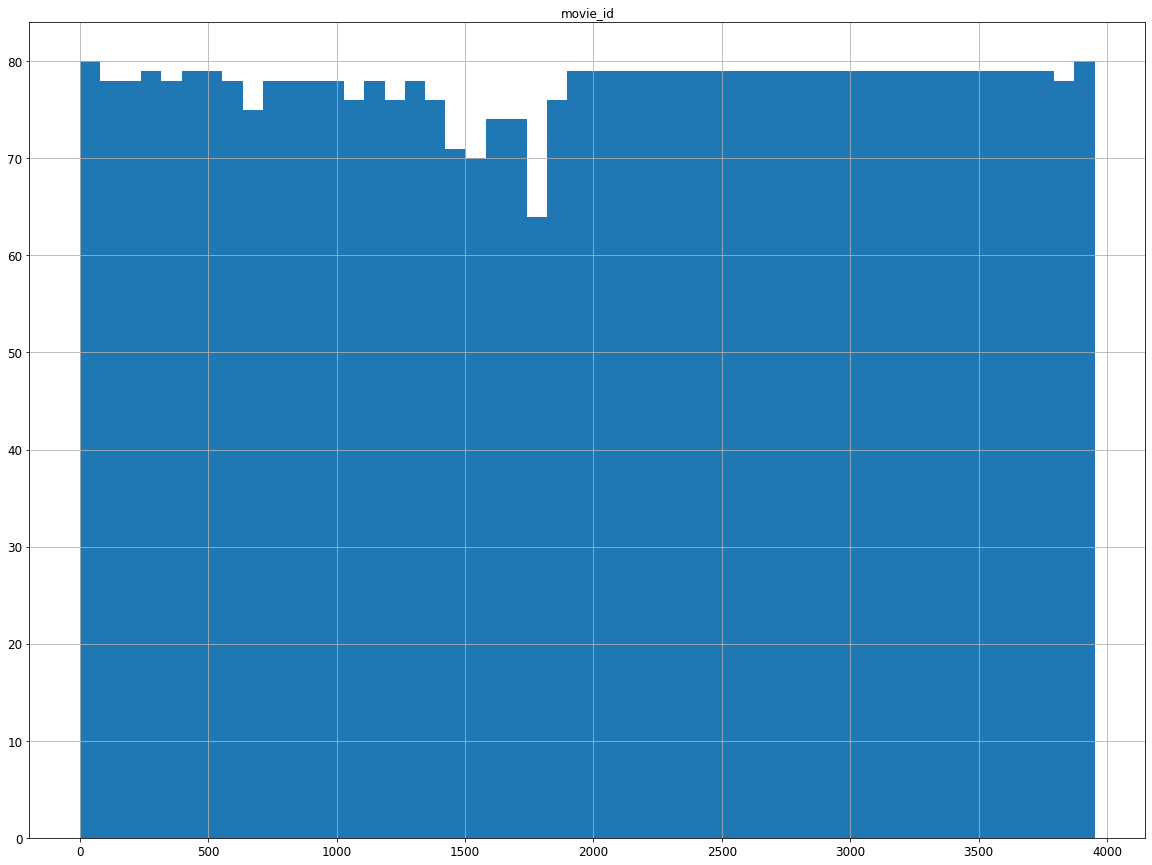

In [30]:
%matplotlib inline
import matplotlib.pyplot as plt
movies.hist(bins=50, figsize=(20,15))
plt.show()

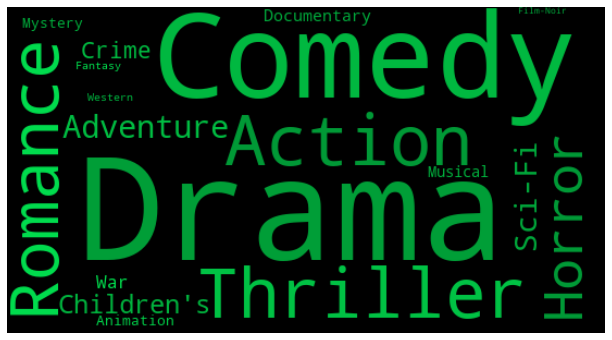

In [31]:
# Function that control the color of the words
def random_color_func(word=None, font_size=None, position=None,
                      orientation=None, font_path=None, random_state=None):
    h = int(360.0 * tone / 255.0)
    s = int(100.0 * 255.0 / 255.0)
    l = int(100.0 * float(random_state.randint(70, 120)) / 255.0)
    return "hsl({}, {}%, {}%)".format(h, s, l)


#Finally, the result is shown as a wordcloud:
words = dict()
trunc_occurences = keyword_occurences[0:50]
for s in trunc_occurences:
    words[s[0]] = s[1]
tone = 100 # define the color of the words
f, ax = plt.subplots(figsize=(14, 6))
wordcloud = WordCloud(width=550,height=300, background_color='black', 
                      max_words=1628,relative_scaling=0.7,
                      color_func = random_color_func,
                      normalize_plurals=False)
wordcloud.generate_from_frequencies(words)
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()

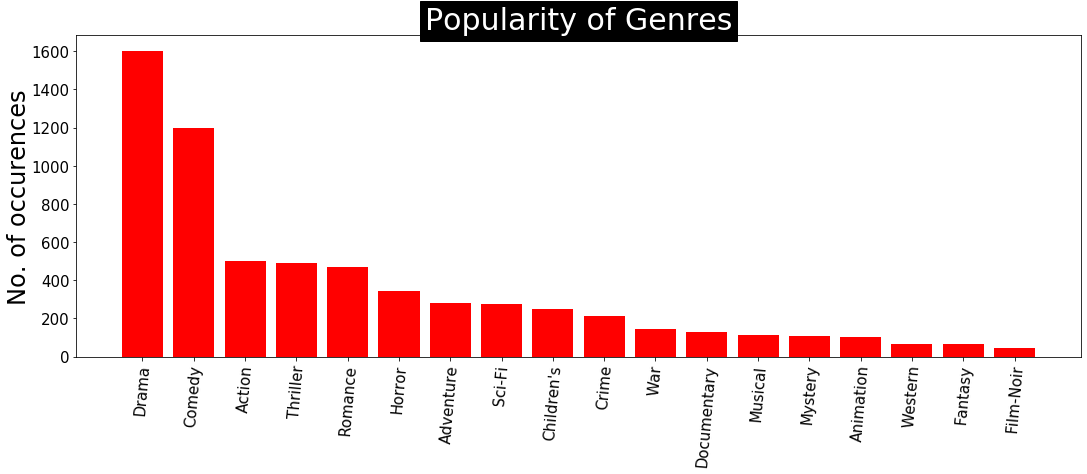

In [32]:
# lets display the same result in the histogram
fig = plt.figure(1, figsize=(18,13))
ax2 = fig.add_subplot(2,1,2)
y_axis = [i[1] for i in trunc_occurences]
x_axis = [k for k,i in enumerate(trunc_occurences)]
x_label = [i[0] for i in trunc_occurences]
plt.xticks(rotation=85, fontsize = 15)
plt.yticks(fontsize = 15)
plt.xticks(x_axis, x_label)
plt.ylabel("No. of occurences", fontsize = 24, labelpad = 0)
ax2.bar(x_axis, y_axis, align = 'center', color='r')
plt.title("Popularity of Genres",bbox={'facecolor':'k', 'pad':5},color='w',fontsize = 30)
plt.show()

In [139]:
import folium
import json
from folium import plugins

#group the ratings dataframe by user's zip code and count the number of ratings in each zip code
numStoresSeries = lens.groupby('zip_code').count().id
#initialize an empty dataframe to store this new data
numStoresByZip = pd.DataFrame()
#populate the new dataframe with a 'zipcode' column and a 'numStores' column
numStoresByZip['zip_code'] = [str(i) for i in numStoresSeries.index]
numStoresByZip['ratings'] = numStoresSeries.values

#initialize the LA County map
laMap = folium.Map(location=[34.0522,-118.2437], tiles='Stamen Toner', zoom_start=9)

#draw the choropleth map. These are the key components:
#--geo_path: the geojson which you want to draw on the map [in our case it is the zipcodes in LA County]

#--data: the pandas dataframe which contains the zipcode information 
# AND the values of the variable you want to plot on the choropleth

#--columns: the columns from the dataframe that you want to use 
#[this should include a geospatial column [zipcode] and a variable [numStores]

#--key_on: the common key between one of your columns and an attribute in the geojson. 
#This is how python knows which dataframe row matches up to which zipcode in the geojson

laMap.choropleth(geo_path='laZips.geojson', data=numStoresByZip, columns=['zipcode', 'numStores'], \
                 key_on='feature.properties.zipcode', fill_color='YlGn', fill_opacity=1)

laMap.save('laChoropleth.html')

ModuleNotFoundError: No module named 'folium'

# 4. Separando o conjunto de dados

Devemos separar o conjunto de dados em treino e teste por meio de amostragem estratificada para manter as propriedades do conjunto original, do contrário corre-se o risco de ao acaso adicionar viés aos dados. Podemos estratificar por:
 - avaliações: conjunto de teste com mesma distribuição de avaliações do conjunto de dados;
 - usuários: conjunto de teste com mesma distribuição ou então garantir pelo menos uma avaliação para testar a predição para todos os usuários;
 - gênero de filmes: conjunto de teste com mesma distribuição de gênero de filmes do conjunto de dados.

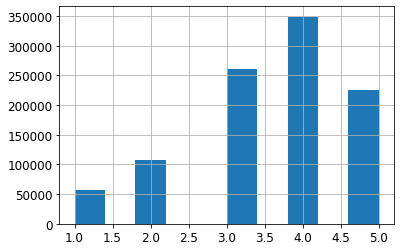

In [34]:
ratings["rating"].hist()

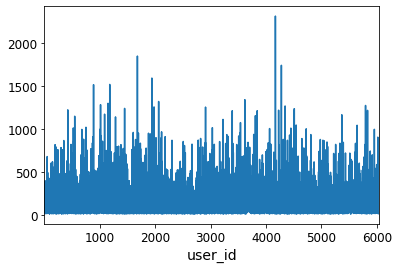

In [41]:
ratings.groupby(["user_id"]).count()["rating"].plot()

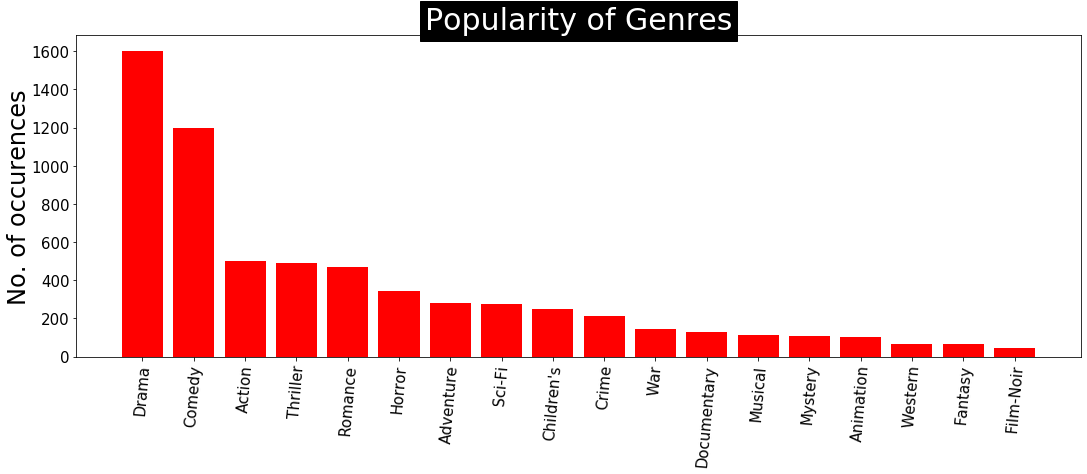

In [44]:
# lets display the same result in the histogram
fig = plt.figure(1, figsize=(18,13))
ax2 = fig.add_subplot(2,1,2)
y_axis = [i[1] for i in trunc_occurences]
x_axis = [k for k,i in enumerate(trunc_occurences)]
x_label = [i[0] for i in trunc_occurences]
plt.xticks(rotation=85, fontsize = 15)
plt.yticks(fontsize = 15)
plt.xticks(x_axis, x_label)
plt.ylabel("No. of occurences", fontsize = 24, labelpad = 0)
ax2.bar(x_axis, y_axis, align = 'center', color='r')
plt.title("Popularity of Genres",bbox={'facecolor':'k', 'pad':5},color='w',fontsize = 30)
plt.show()

Vamos fazer uma <font color='red'>amostragem estratificada</font> com base nos ratings.  

In [45]:
from sklearn.model_selection import StratifiedShuffleSplit

split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_index, test_index in split.split(lens, lens["rating"]):
    strat_train_set = lens.loc[train_index]
    strat_test_set = lens.loc[test_index]

Acabamos de criar novos conjuntos de treino e de teste, que chamamos de <font color='red'>strat_train_set </font> e <font color='blue'>strat_test_set</font>.

 Vejamos se funcionou:

In [46]:
strat_test_set["rating"].value_counts() / len(strat_test_set) #Proporção de cada valor de avaliação em strat_test_set

4    0.348897
3    0.261145
5    0.226262
2    0.107532
1    0.056163
Name: rating, dtype: float64

In [47]:
lens["rating"].value_counts() / len(lens) #Proporção de cada valor de avaliação em lens

4    0.348898
3    0.261142
5    0.226263
2    0.107535
1    0.056162
Name: rating, dtype: float64

In [54]:
strat_test_set["user_id"].value_counts() / len(strat_test_set) #Proporção de cada usuário em strat_test_set
#Quantidade de usuário distintos em strat_test_set: 6036 
#4 usuários sem teste de predição pois todas as avaliações estão no treino

4169    0.002439
1680    0.001895
4277    0.001750
1941    0.001590
1181    0.001490
889     0.001490
1150    0.001445
2063    0.001425
3618    0.001340
3841    0.001325
4510    0.001305
4227    0.001300
1449    0.001295
1980    0.001290
1285    0.001270
2909    0.001265
5795    0.001265
5831    0.001260
1015    0.001245
424     0.001240
4344    0.001165
4508    0.001155
1088    0.001150
5643    0.001135
3539    0.001130
5367    0.001120
3808    0.001110
3391    0.001110
3032    0.001100
4064    0.001080
          ...   
503     0.000005
5358    0.000005
951     0.000005
98      0.000005
4324    0.000005
4996    0.000005
5467    0.000005
3406    0.000005
3021    0.000005
1993    0.000005
2657    0.000005
1994    0.000005
2735    0.000005
1385    0.000005
4383    0.000005
2920    0.000005
2839    0.000005
1174    0.000005
3234    0.000005
5122    0.000005
2530    0.000005
2152    0.000005
3040    0.000005
5409    0.000005
407     0.000005
4787    0.000005
4943    0.000005
2816    0.0000

In [50]:
lens["user_id"].value_counts() / len(lens) #Proporção de cada categoria em housing

4169    0.002314
1680    0.001850
4277    0.001743
1941    0.001595
1181    0.001521
889     0.001518
3618    0.001344
2063    0.001323
1150    0.001302
1015    0.001286
5795    0.001277
4344    0.001271
1980    0.001260
2909    0.001258
1449    0.001243
4510    0.001240
424     0.001226
4227    0.001222
5831    0.001220
3391    0.001216
3841    0.001216
4508    0.001211
1088    0.001176
5367    0.001169
3808    0.001158
549     0.001152
1285    0.001144
3224    0.001115
3539    0.001078
4543    0.001050
          ...   
5309    0.000020
703     0.000020
932     0.000020
160     0.000020
5027    0.000020
2292    0.000020
1664    0.000020
5904    0.000020
3633    0.000020
4365    0.000020
4628    0.000020
5258    0.000020
2530    0.000020
5168    0.000020
5380    0.000020
3552    0.000020
4749    0.000020
2819    0.000020
6038    0.000020
5012    0.000020
4244    0.000020
5525    0.000020
3222    0.000020
250     0.000020
665     0.000020
761     0.000020
1493    0.000020
5533    0.0000

In [119]:
keyword_occurences, dum = count_word(movies, 'genres', genre_labels)
total_movies = len(movies)
flat_list = [(x, y / total_movies) for x, y in keyword_occurences]
flat_list

[('Drama', 0.4128251352047386),
 ('Comedy', 0.3090394025238218),
 ('Action', 0.12953901622456862),
 ('Thriller', 0.12670615503476693),
 ('Romance', 0.12129796549060005),
 ('Horror', 0.08833376255472573),
 ('Adventure', 0.07288179242853464),
 ('Sci-Fi', 0.07107906258047901),
 ("Children's", 0.06464074169456606),
 ('Crime', 0.054339428277105334),
 ('War', 0.036827195467422094),
 ('Documentary', 0.032706670100437804),
 ('Musical', 0.02935874323976307),
 ('Mystery', 0.027298480556270925),
 ('Animation', 0.027040947720834405),
 ('Fantasy', 0.017512232809683236),
 ('Western', 0.017512232809683236),
 ('Film-Noir', 0.0113314447592068)]

In [117]:
df = strat_test_set[['movie_id', 'genres']].drop_duplicates()

In [120]:
keyword_occurences, dum = count_word(df, 'genres', genre_labels)
total_movies = len(df)
flat_list = [(x, y / total_movies) for x, y in keyword_occurences]
flat_list

[('Drama', 0.3939045428407131),
 ('Comedy', 0.3182863714778608),
 ('Action', 0.13801035077630822),
 ('Thriller', 0.1336975273145486),
 ('Romance', 0.1276595744680851),
 ('Horror', 0.09430707303047729),
 ('Adventure', 0.07878090856814261),
 ('Sci-Fi', 0.078205865439908),
 ("Children's", 0.07130534790109258),
 ('Crime', 0.055204140310523286),
 ('War', 0.039390454284071307),
 ('Musical', 0.03162737205290397),
 ('Animation', 0.030189764232317423),
 ('Mystery', 0.02903967797584819),
 ('Documentary', 0.027314548591144336),
 ('Fantasy', 0.01926394479585969),
 ('Western', 0.018113858539390456),
 ('Film-Noir', 0.012075905692926969)]

## 4.1. Visualização da estrutura de dados

Vamos agora visualizar os nossos dados. Precisamos ter certeza que não vamos visualizar dados do conjunto de teste, para evitar enviesamento de conclusões.

In [121]:
lens_train = strat_train_set.copy() #Importante criar uma cópia! 

A visulização dos dados indicam que regiões litorâneas tendem a possuir um valor mais alto. Talevz a densidade populacional também possa ser algo relevante.

Vamos então investigar essas hipóteses através da correleção estatística:

In [122]:
corr_matrix = lens_train.corr() #Matriz de correlações com variáveis numéricas

In [123]:
corr_matrix #Fracas correlações com avaliação, existe certa correlação inversa entre user_id e timestamp.

,movie_id,user_id,rating,unix_timestamp,age,occupation
movie_id,1.000000,-0.018321,-0.064522,0.041962,0.027374,0.007546
user_id,-0.018321,1.000000,0.013126,-0.491764,0.033926,-0.027204
rating,-0.064522,0.013126,1.000000,-0.026839,0.056686,0.006775
unix_timestamp,0.041962,-0.491764,-0.026839,1.000000,-0.064083,0.015866
age,0.027374,0.033926,0.056686,-0.064083,1.000000,0.078829
occupation,0.007546,-0.027204,0.006775,0.015866,0.078829,1.000000


In [124]:
corr_matrix["rating"].sort_values(ascending=False) #Ordenar valores em sentido decrescente

rating            1.000000
age               0.056686
user_id           0.013126
occupation        0.006775
unix_timestamp   -0.026839
movie_id         -0.064522
Name: rating, dtype: float64

As correlações poderiam ser analisadas do seguinte modo:
 - Um usuário mais velho pode ser mais crítico em sua avaliação, dando notas menores. Assim como uma criança pode dar apenas notas altas ou baixas.
 - Um usuário pode ser mais criterioso que outro em sua forma de avaliar.
 - Um usuário de determinada ocupação pode ser mais criterioso que os de demais.
 - A medida que o tempo passa os usuários tornam-se mais/menos criteriosos.
 - Um determinado filme pode ser geralmente mais bem avaliado que o outro devido a sua qualidade.

É conveniente usar o scatter_matrix do pandas. Essa função plota cada característica em relação a outra.

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000001A992A5BE80>,
      dtype=object)

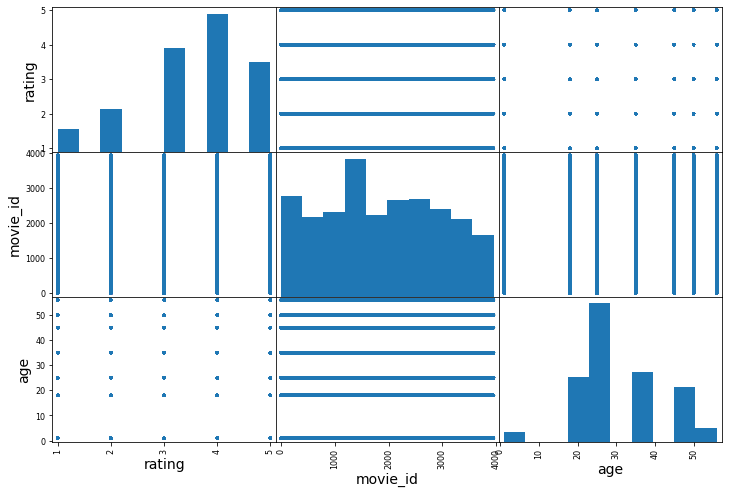

In [138]:
from pandas.plotting import scatter_matrix

attributes = ["rating", "movie_id", "age"]
scatter_matrix(lens_train[attributes], figsize=(12, 8))

OBS: Na diagonal principal da plotagem anterior não temos atributo x atributo, mas sim o histograma da característica.

Vimos antes, que a característica numérica que tinha maior correleção com o valor da avaliação era o id do filme. Então vamos plotar para estudar a relação entre ambos:

[0, 4000, 0, 6]

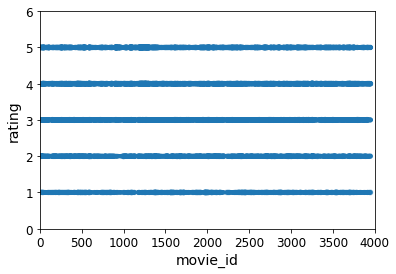

In [136]:
lens_train.plot(kind="scatter", x="movie_id", y="rating", s=lens_train.groupby(['movie_id']).count()['rating'] / 100,
             alpha=0.4)
plt.axis([0, 4000, 0, 6])

Informações desta plotagem: 

1) Correlação é fraca;

2) Correlação com id do item não é algo muito informativo, mas pode ser explicada pelo viés de um filme em receber determinada avaliação (um filme bom é bem avaliado pela maiora das pessoas).

## 4.2. Feature Engineering

Além das colunas que o conjunto de dados nos oferece, podemos tentar construir novas características <font color = "red">construídas de maneiras não linear</font> com as características existentes. Por exemplo:

- A quantidade de filmes avaliados tem correlação com o valor da avaliação?
- A taxa avaliação por tempo de um usuário tem correlação? 
- A quantidade de gêneros de um filme? 

A seguir, vamos construir as novas features:

In [ ]:
#Nova feature: Número de cômodos por familia (média)
housing["rooms_per_household"] = housing["total_rooms"]/housing["households"]

#Nova feature: quartos/cômodos
housing["bedrooms_per_room"] = housing["total_bedrooms"]/housing["total_rooms"]

#Nova feature: população/agregado familiar
housing["population_per_household"]=housing["population"]/housing["households"]

Vejamos agora a matriz de correlação de housing:

In [ ]:
corr_matrix = housing.corr()
corr_matrix["median_house_value"].sort_values(ascending=False)

Aparentemente, casas com uma baixa proporção de quartos para cômodas tendem a ser mais caras. O número de cômodos por família é muito mais informartivo que o número total de quartos em um quarteirão.

Vejamos o gráfico:

In [ ]:
housing.plot(kind="scatter", x="rooms_per_household", y="median_house_value",
             alpha=0.2)
plt.axis([0, 5, 0, 520000])
plt.show()

Vamos ver novamente as medidas resumos considerando as novas features!

In [ ]:
housing.describe()

# 5. Preparar os dados para os algoritmos de Machine Learning

Precisamos incialmente retirar os rótulos do conjunto <fon color='blue'> strat_train_set </font> (mais a frente ficará claro).

- Usuários de uma mesma região votam de maneira similar?
- Usuários do mesmo sexo votam de maneira similar?
- Filmes de um mesmo genero são avaliados de maneira similar?

Para isso, vamos usar o método drop:

In [ ]:
housing = strat_train_set.drop("median_house_value", axis=1) # O método drop cria cópia sem a coluna em questao
housing_labels = strat_train_set["median_house_value"].copy() #salvando uma cópia

A partir de agora vamos partir para etapa de <font color='blue'>limpeza de dados!</font>

Vamos começar verificandi se temos dados falantes:

In [ ]:
#housing.isnull().any(axis=1) verifica quais linhas possuem alguma célula null
sample_incomplete_rows = housing[housing.isnull().any(axis=1)].head()
sample_incomplete_rows

Possuímos basicamente três abordagens possíveis para lidar com os dados faltantes:

1. Excluir os quarteirões com dados faltantes;

2. Excluir toda coluna de total_bedrooms, já que é o único atributo que apresenta dados faltantes;

3. Definir algum valor para substituir total_bedrooms.

In [ ]:
sample_incomplete_rows.dropna(subset=["total_bedrooms"])    # opção 1

In [ ]:
sample_incomplete_rows.drop("total_bedrooms", axis=1)       # opção 2

Opção 3: preenchendo com algum valor - nesse caso, usaremos a mediana.

In [ ]:
median = housing["total_bedrooms"].median()
sample_incomplete_rows["total_bedrooms"].fillna(median, inplace=True) # opção 3
sample_incomplete_rows

Se escolhermos a opção 3, devemos calular a mediana (ou qualquer outra medida que seja justificável) no <font color="red">conjunto de treinamento</font> e usá-lo para preencher os valores faltantes neste, mas precisamos <font color="blue">salvar</font> esse valor cálculado.

Você precisar desse valor para mais tarde aplicar no conjunto de teste, que deverá ter seus dados faltantes corrigidos seguindo o mesmo parâmetro do conjunto de treino.

**AVISO**: No Scikit-Learn 0.20, a classe `sklearn.preprocessing.Imputer` 
foi substituida pela classe `sklearn.impute.SimpleImputer`. Então, é conviniente verificar qual versão o computador em questão está usando:

In [ ]:
try:
    from sklearn.impute import SimpleImputer # Scikit-Learn 0.20+
    print("Scikit-Learn 0.20+")
except ImportError:
    from sklearn.preprocessing import Imputer as SimpleImputer
    print("Scikit-Learn antes do 0.20")

imputer = SimpleImputer(strategy="median")

Vamos novamente revisar o nosso dataset...

In [ ]:
housing

Ainda temos a última coluna que não é numérica! 

A princípios, grande parte dos algoritmos de machine learning no computador preferem os dados representados numericamente!

In [ ]:
housing_num = housing.drop('ocean_proximity', axis=1)
# Derrubando a coluna "ocean_proximity"
# alternativa: housing_num = housing.select_dtypes(include=[np.number])

Agora vamos ajudar o nosso objeto imputer com o nossos dados:

In [ ]:
imputer.fit(housing_num) 

Aqui, o imputer simplesmente calculou a mediana no conjunto de dados.

Vejamos algumas informações sobre o nosso objeto imputer:

In [ ]:
imputer.statistics_

Vamos verificar que isto é, na verdade, a mesma coisa que calcular manualmente a mediana de cada atributo:

In [ ]:
housing_num.median().values

Mas não seria apenas o atributo "total_bedrooms" que estava com valores faltantes? 

Vamos precisar de todas as informações do imputer? Isto é, vamos precisar da mediana de todas as variáveis?

<font color='red'> Não podemos, a princípio, afirmar que o mesmo padrão vai ser repetir na generalização do modelo! </font>

Certo, mas e se dermos uma espiadinha no conjunto de testes?

Não devemos fazer isso por vários motivos. 

1. Corremos o risco de colocar vieses no nosso modelo (assumir que apenas "total_bedrooms" terá colunas com dados faltantes em todos os cenários possíveis é um deles;

2. Devemos ter sempre em mente que o conjunto de teste é no fundo uma simulação para testarmos o poder de generalização do algoritmo - devemos fazer todas as nossas análises e otimizações somente no conjunto de treinamento e então aplicar o modelo final uma única vez no conjunto de teste!



Vamos agora finalmente <font color = 'blue'> transformar </font> o nosso conjunto de dados, aplicando, efetivamente, o valor calculado da mediana nos dados faltantes:

In [ ]:
X = imputer.transform(housing_num) #numpy array

Vamos visualizar o conjunto X

In [ ]:
X

Se você se sentir mais confortável, pode transformar o conjunto X em um dataframe:

In [ ]:
housing_tr = pd.DataFrame(X, columns=housing_num.columns, #importante informar nome das colunas
                          index=housing.index) #DataFrame Pandas

Vejamos como é este dataframe:

In [ ]:
housing_tr.head()

Agora devemos tratar a variável categórica`ocean_proximity'!

Lembre que esta é uma variável muito importante no nosso problema: ela demonstrava uma boa correlação com o preço mediano das casas.

Vamos novamente visualizar os dados para relembrar:

In [ ]:
housing_cat = housing[['ocean_proximity']]
housing_cat.head(10)

Agora vamos usar um processo chamado de codificação. Vamos transformar as nossas variáveis categóricas em números!

**OBS**: O código a seguir é apenas devido a atualização da classe OriginalEnconder()

In [ ]:
try:
    from sklearn.preprocessing import OrdinalEncoder
    print("Scikit-Learn >= 2.0")
except ImportError:
    from future_encoders import OrdinalEncoder # Scikit-Learn < 0.20
    print("O teu Scikit-Learn tá antiguinho mô quirido")

Na função a seguir, precisamos instanciar um objeto ordinal_encoder. 

Depois, usamos fit_transform para executa duas operações:

1. Método fit irá ajustar os parâmetros (mapeamento, por exemplo, quais são as variáveis categóricas); 

2. Método transform irá transformar os dados;

3. fit_transform(dados) irá ajustar parâmetros e transformar os dados.


In [ ]:
ordinal_encoder = OrdinalEncoder()
housing_cat_encoded = ordinal_encoder.fit_transform(housing_cat)

Uma alternativa mais prolixa teria sido escrever:

original_encoder.fit(housing_cat)

housing_cat_encoded = original_enconder.fit(housing_cat)


Vejamos que tipo de objeto é housing_cat_encoded:

In [ ]:
type(housing_cat_encoded)

Vamos ver agora os 10 primeiros valores desse numpy array:

In [ ]:
housing_cat_encoded[:10]

Vamos relembrar também as categorias do nosso problema:

In [ ]:
ordinal_encoder.categories_

Veja! 

O objeto ordinal_encoder foi construiído assim:

ordinal_encoder = OrdinalEncoder() 

e depois fizemos o seguinte:

housing_cat_encoded = ordinal_encoder.fit_transform(housing_cat)

<font color = "red">Aqui não apenas definimos quem é "housing_cat_encoded" como também inserimos informações no objeto ordinal_encoder! </font>

Apesar dos nossos esforços, temos um grave problema na nossa codificação, veja novamente: 

In [ ]:
housing_cat_encoded[:10]

In [ ]:
housing_cat[:10]

Cada variável categórica foi transformada em número!

Mas será que a princípio, podemos comparar uma variável categórica com outra?

Quem é maior: NEAR OCEAN ou NEAR BAY? 

Bem, é difícil responder. Mas é isso que a nossa codificação implicítacamente está fazendo ao colocar os valores 0,1,2,3 ou 4 para cada variável categórica. 

<font color="red"> Para lidar com essa situação precisamos então de outra abordagem!</font>

In [ ]:
try:
    from sklearn.preprocessing import OrdinalEncoder # gera um ImportError se Scikit-Learn < 0.20
    from sklearn.preprocessing import OneHotEncoder
except ImportError:
    from future_encoders import OneHotEncoder # Scikit-Learn < 0.20

cat_encoder = OneHotEncoder()
housing_cat_1hot = cat_encoder.fit_transform(housing_cat)
housing_cat_1hot

By default, the `OneHotEncoder` class returns a sparse array, but we can convert it to a dense array if needed by calling the `toarray()` method:

Epa! Agora temos uma matriz SciPy ao invés de um Numpy array! 

<font color = "red">Por que será?</font>

In [ ]:
housing_cat_1hot.toarray()

Temos agora uma matriz esparsa! (mais econômica computacionalmente)

Alternativamente, podemos colocar `sparse=False` ao criar o objeto `OneHotEncoder`:

In [ ]:
cat_encoder = OneHotEncoder(sparse=False)
housing_cat_1hot = cat_encoder.fit_transform(housing_cat)
housing_cat_1hot

In [ ]:
cat_encoder.categories_

Let's create a custom transformer to add extra attributes:

Vamos criar um transformador customizado para adicionar atributos extras 

**OBS**: aqui vamos simplesmente criar um código para o processo manual feito na etapa de Feature Engineering. Vai nos ajudar a criar um pipeline mais a frente.

In [ ]:
housing.columns

In [ ]:
from sklearn.base import BaseEstimator, TransformerMixin

# Buscando os indices corretos das colunas: 
# Mais seeguro que ficar digitando 3, 4, 5, 6..
rooms_ix, bedrooms_ix, population_ix, household_ix = [
    list(housing.columns).index(col)
    for col in ("total_rooms", "total_bedrooms", "population", "households")]

class CombinedAttributesAdder(BaseEstimator, TransformerMixin):
    def __init__(self, add_bedrooms_per_room = True): # no *args or **kwargs
        self.add_bedrooms_per_room = add_bedrooms_per_room
    def fit(self, X, y=None):
        return self  # Nada a fazer!
    def transform(self, X, y=None):
        rooms_per_household = X[:, rooms_ix] / X[:, household_ix]
        population_per_household = X[:, population_ix] / X[:, household_ix]
        if self.add_bedrooms_per_room:
            bedrooms_per_room = X[:, bedrooms_ix] / X[:, rooms_ix]
            return np.c_[X, rooms_per_household, population_per_household,
                         bedrooms_per_room]
        else:
            return np.c_[X, rooms_per_household, population_per_household]

attr_adder = CombinedAttributesAdder(add_bedrooms_per_room=False)
housing_extra_attribs = attr_adder.transform(housing.values)

Alternativamente, você pode usar a função da classe `FunctionTransformer` que permite você criar rapidamente um transformador baseado em uma função de transformação! 

In [ ]:
from sklearn.preprocessing import FunctionTransformer

def add_extra_features(X, add_bedrooms_per_room=True):
    rooms_per_household = X[:, rooms_ix] / X[:, household_ix]
    population_per_household = X[:, population_ix] / X[:, household_ix]
    if add_bedrooms_per_room:
        bedrooms_per_room = X[:, bedrooms_ix] / X[:, rooms_ix]
        return np.c_[X, rooms_per_household, population_per_household,
                     bedrooms_per_room]
    else:
        return np.c_[X, rooms_per_household, population_per_household]

attr_adder = FunctionTransformer(add_extra_features, validate=False,
                                 kw_args={"add_bedrooms_per_room": False})

housing_extra_attribs = attr_adder.fit_transform(housing.values)

#Vale a pena colocar validate=False já queos dados não possuem valores não-float
#validate=false é valor padrão a partir do Scikit-Learn 0.22.

In [ ]:
housing_extra_attribs = pd.DataFrame(
    housing_extra_attribs,
    columns=list(housing.columns)+["rooms_per_household", "population_per_household"],
    index=housing.index)
housing_extra_attribs.head()

Agora vamos construir um "pipeline" (tradução literal: gasoduto) para pré-processar os atributos numéricos - obser que poderíamos usar <font color = 'blue'> CombinedAttributesAdder()</font>
ao invés do <font color = 'blue'> FunctionTransformer(...) </font>, se quiséssemos:

In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler 
#StandardScaler serve para fazer a reescalar das variáveis

num_pipeline = Pipeline([
        ('imputer', SimpleImputer(strategy="median")),
        ('attribs_adder', FunctionTransformer(add_extra_features, validate=False)),
        ('std_scaler', StandardScaler()),
    ])

housing_num_tr = num_pipeline.fit_transform(housing_num)

In [ ]:
housing_num_tr

In [ ]:
try:
    from sklearn.compose import ColumnTransformer
except ImportError:
    from future_encoders import ColumnTransformer # Scikit-Learn < 0.20

In [ ]:
num_attribs = list(housing_num)
cat_attribs = ["ocean_proximity"]

full_pipeline = ColumnTransformer([
        ("num", num_pipeline, num_attribs),
        ("cat", OneHotEncoder(), cat_attribs),
    ])

housing_prepared = full_pipeline.fit_transform(housing)

In [ ]:
housing_prepared

In [ ]:
housing_prepared.shape

Agora finalmente temos os nossos dados pré-processados! 

# 6. Selecionar e treinar um modelo

Vamos começar com um modelo siples: Regressão Linear!

In [ ]:
from sklearn.linear_model import LinearRegression

lin_reg = LinearRegression()
lin_reg.fit(housing_prepared, housing_labels) 
#Ei Regressão linear, encontre os parâmetros que melhor aproxima os dados

Vamos agora testar o nosso pipeline de pré-processamento em algumas instâncias de treino.

In [ ]:
some_data = housing.iloc[:5]
some_labels = housing_labels.iloc[:5]
some_data_prepared = full_pipeline.transform(some_data) 

print("Predictions:", lin_reg.predict(some_data_prepared))

Vamos comparar agora com os valores reais:


In [ ]:
print("Labels:", list(some_labels))

In [ ]:
some_data_prepared

Agora vamos usar as métricas que aprendemos anteriormente!

In [ ]:
from sklearn.metrics import mean_squared_error as MSE

housing_predictions = lin_reg.predict(housing_prepared)
lin_mse = MSE(housing_labels, housing_predictions)
lin_rmse = np.sqrt(lin_mse) #Não é necessariamente obrigatório
lin_rmse

In [ ]:
from sklearn.metrics import mean_absolute_error as MAE

lin_mae = MAE(housing_labels, housing_predictions)
lin_mae

Essse modelo ainda não parece ser adequado!

In [ ]:
from sklearn.tree import DecisionTreeRegressor

tree_reg = DecisionTreeRegressor(random_state=42)
tree_reg.fit(housing_prepared, housing_labels)

In [ ]:
housing_predictions = tree_reg.predict(housing_prepared)
tree_mse = MSE(housing_labels, housing_predictions)
tree_rmse = np.sqrt(tree_mse)
tree_rmse

O quê? Erro zero?

#Vamos continuar na próxima aula a calibrar esse modelo!

# 7. Ajustar o modelo

# 8. Apresentar sua solução

# 9. Lançar, monitorar e manter seu sistema

# Bibliografia

1. F. Maxwell Harper and Joseph A. Konstan. 2015. The MovieLens Datasets: History and Context. ACM Transactions on Interactive Intelligent Systems (TiiS) 5, 4, Article 19 (December 2015), 19 pages. DOI=http://dx.doi.org/10.1145/2827872

